Lets begin once again by loading our data.

In [10]:
import pickle
import nltk
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer #word counts, idf and tf-idf values
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.spatial.distance import cdist
   
with open('../data/sentiment_scores.pkl', 'rb') as file:
    try:
        sentiment_scores = pickle.load(file)
        print("Sentiment scores loaded successfully.")
    except EOFError:
        print("Error: Sentiment scores is empty or corrupted.")    

sentiment_scores     

Sentiment scores loaded successfully.


,Movie,Review,word_sentiment,sentiment_score
0,Ghost Ship,Sean Murphy crew top salvage experts land sea ...,positive,-0.00
1,The Craft,SPOILERSI thought decent teen flick remember e...,negative,-0.02
2,House of 1000 Corpses,opinion House 1000 Corpses fan Fans genre Rob ...,negative,-0.01
3,The Haunting of Bly Manor,many people saying right Haunted house tales g...,positive,0.03
4,Attack on Titan,moment watch audiovisual masterpiece immediate...,positive,0.02
...,...,...,...,...
75,Stranger Things,Stranger Things 1980s inspired themed science ...,positive,0.03
76,Fear the Walking Dead,whole help people silly boring dialogue pure e...,positive,0.02
77,The Haunting of Hill House,never written review series undoubtedly deserv...,positive,0.01
78,American Horror Story,American story great kind people slasher movie...,negative,-0.01


Where do we begin when we have features based on text. We can do feature engineering by creating new features that reflect counts of words using a simple count like below, this is also called word/term frequencies. Better is the most frequent word in the movie Ghost Ship for our review.

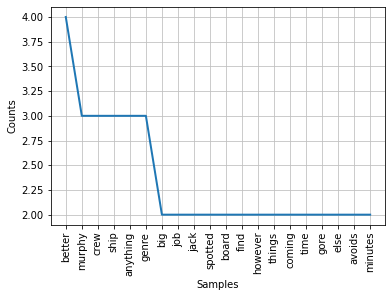

<Axes: xlabel='Samples', ylabel='Counts'>

In [2]:
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist

ghost_ship_review = sentiment_scores.iloc[0, 1]

fdist = FreqDist(word.lower() for word in word_tokenize(ghost_ship_review))

fdist.plot(20,cumulative=False)


In [3]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
cv = CountVectorizer()
word_count_vector = cv.fit_transform(sentiment_scores['Review'])
tf = pd.DataFrame(word_count_vector.toarray(), columns=cv.get_feature_names_out())
tf.head()

,00,000,00am,10,100,1000,103,11,13th,15,...,younger,zealot,zero,zeta,zetterlig,zoe,zombie,zombieland,zombies,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,6,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We can take things to another level and use differential frequency analysis. This helps identify phrases that are more come in this review than in most others. How exactly, this creates weights for that scale up rare terms and weights down frequent ones, e.g. "if" "else". Compare the word better which has a larger weight than the word 

In [4]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()
X = tfidf_transformer.fit_transform(word_count_vector)
idf = pd.DataFrame({'feature_name':cv.get_feature_names_out(), 'idf_weights':tfidf_transformer.idf_})
print(idf)

     feature_name  idf_weights
0              00     4.701302
1             000     4.295837
2            00am     4.701302
3              10     2.450010
4             100     4.295837
...           ...          ...
3909          zoe     4.701302
3910       zombie     3.197225
3911   zombieland     4.701302
3912      zombies     3.315008
3913         zone     4.295837

[3914 rows x 2 columns]


# TF-IDF

Lets combine both term frequency with inverse document frequency. 

In [5]:

vectorizer = TfidfVectorizer()

X = vectorizer.fit_transform(sentiment_scores['Review'])

feature_names = vectorizer.get_feature_names_out() #FEATURE_WORDS

feature_names

array(['00', '000', '00am', ..., 'zombieland', 'zombies', 'zone'],
      dtype=object)

# Unsupervised learning with Kmeans clustering

We have many movies, so lets create groups from them or in ML jargon, clusters. However because we do not have labels in our data we will use kmeans clustering.

In [6]:
km = KMeans(n_clusters=10, init='k-means++', max_iter=100, n_init=1, random_state=3) # set parameters

km_object = km.fit(X)

sentiment_scores['Cluster'] = km_object.labels_

sentiment_scores

,Movie,Review,word_sentiment,sentiment_score,Cluster
0,Ghost Ship,Sean Murphy crew top salvage experts land sea ...,positive,-0.00,6
1,The Craft,SPOILERSI thought decent teen flick remember e...,negative,-0.02,2
2,House of 1000 Corpses,opinion House 1000 Corpses fan Fans genre Rob ...,negative,-0.01,9
3,The Haunting of Bly Manor,many people saying right Haunted house tales g...,positive,0.03,7
4,Attack on Titan,moment watch audiovisual masterpiece immediate...,positive,0.02,8
...,...,...,...,...,...
75,Stranger Things,Stranger Things 1980s inspired themed science ...,positive,0.03,4
76,Fear the Walking Dead,whole help people silly boring dialogue pure e...,positive,0.02,5
77,The Haunting of Hill House,never written review series undoubtedly deserv...,positive,0.01,8
78,American Horror Story,American story great kind people slasher movie...,negative,-0.01,8


In [7]:
topn_features=5
num_clusters=10

cluster_details = {}
 # get cluster centroids
ordered_centroids = km_object.cluster_centers_.argsort()[:, ::-1]

for cluster_num in range(num_clusters):
    cluster_details[cluster_num] = {}
    cluster_details[cluster_num]['cluster_num'] = cluster_num
    key_features = [feature_names[index] for index in ordered_centroids[cluster_num, :topn_features]]
    cluster_details[cluster_num]['key_features'] = key_features
    movies = sentiment_scores[sentiment_scores['Cluster'] == cluster_num]['Movie'].values.tolist()
    cluster_details[cluster_num]['movies'] = movies

cluster_details

{0: {'cluster_num': 0,
  'key_features': ['scream', 'craven', 'franchise', 'friday', '13th'],
  'movies': ['Friday the 13th',
   'Scream 2',
   'Scream 4',
   'A Nightmare on Elm Street',
   'Scream']},
 1: {'cluster_num': 1,
  'key_features': ['great', 'fun', 'think', 'zombie', 'zombies'],
  'movies': ['Tarantula',
   'The Haunted Mansion',
   'iZombie',
   'The Hunt',
   'Alone',
   'Overlord',
   'The Babysitter: Killer Queen',
   'Get Out',
   'Monsterland']},
 2: {'cluster_num': 2,
  'key_features': ['think', 'oldman', 'decent', 'fright', 'teen'],
  'movies': ['The Craft',
   'Fright Night',
   'Legacies',
   "Bram Stoker's Dracula",
   'Possessor',
   'Helstrom']},
 3: {'cluster_num': 3,
  'key_features': ['love', 'exorcist', 'loud', 'laugh', 'alien'],
  'movies': ['The Shining',
   'The Fly',
   'The Last House on the Left',
   'Psycho',
   'The Twilight Zone',
   'The Exorcist',
   'The Turning',
   'The Thing',
   'Alien',
   'What We Do in the Shadows',
   'Halloween',
   'Th

In [8]:
cluster_summary_stats = sentiment_scores.groupby('Cluster').agg({'sentiment_score': ['mean', 'median', 'min', 'max']})

cluster_summary_stats

sentiment_score                   
                   mean median   min   max
Cluster                                   
0              0.034000   0.04  0.01  0.05
1              0.037778   0.03 -0.02  0.11
2              0.015000   0.01 -0.02  0.07
3              0.022500   0.01 -0.04  0.09
4              0.020000   0.02 -0.00  0.05
5             -0.003750   0.00 -0.05  0.03
6              0.015455   0.01 -0.03  0.08
7              0.010000   0.02 -0.03  0.03
8              0.022000   0.02 -0.01  0.07
9              0.005000   0.00 -0.05  0.07

On average cluster 1 had higher positive sentiment scores. Common features that help contribute to this score are these movies are described as fun and have zombies. Cluster 5 on average had the lowest scores, with common features that include negative sentiment through words such as 'boring'. Overall there is positive sentiment for horror movies, but not exactly great films. Up next, lets find out what exactly is boring above these movies by using ngrams and chunkers.